In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [1]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-02 13-59-43.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-02 13-59-43_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_09.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary_09.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1752249017.856407 23549719 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752249017.863307 23551306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752249017.867490 23551306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752249017.919922 23551304 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Detected FPS from PyAV: 60.0
-------- Detection Report --------
Total frames: 11607
Frames with at least 1 hand detected: 6416
Detection rate: 55.28%


In [11]:
df = pd.read_csv("hand_landmarks_09.csv")

print("Shape:", df.shape)
df

Shape: (372099, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.000000,Left,0,0.708243,0.852142,-1.562541e-07,1
1,0,0.000000,Left,1,0.719291,0.781728,-2.748869e-02,1
2,0,0.000000,Left,2,0.727318,0.720224,-2.504756e-02,1
3,0,0.000000,Left,3,0.724962,0.670407,-1.727604e-02,1
4,0,0.000000,Left,4,0.719267,0.635714,-7.325560e-03,1
...,...,...,...,...,...,...,...,...
372094,11606,193.466667,Right,16,NaN,NaN,NaN,0
372095,11606,193.466667,Right,17,NaN,NaN,NaN,0
372096,11606,193.466667,Right,18,NaN,NaN,NaN,0
372097,11606,193.466667,Right,19,NaN,NaN,NaN,0


In [14]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()

In [17]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,0,0.000,Left,1,0.708243,0.719291,0.727318,0.724962,0.719267,0.761391,...,0.015398,0.005726,0.045007,0.038370,0.016824,0.004854,0.056219,0.046449,0.030469,0.021166
1,1,0.017,Left,1,0.704539,0.718753,0.726468,0.724693,0.719930,0.758074,...,0.024389,0.012776,0.050035,0.046846,0.024530,0.010572,0.059823,0.053464,0.037889,0.027743
2,2,0.033,Left,1,0.705226,0.717288,0.725942,0.724882,0.716832,0.757138,...,0.029705,0.018361,0.052838,0.052203,0.031122,0.017393,0.063038,0.058572,0.043977,0.034257
3,3,0.050,Left,1,0.705681,0.717237,0.725261,0.723949,0.716978,0.757697,...,0.032287,0.020988,0.054712,0.054826,0.033886,0.020161,0.065152,0.061163,0.046578,0.036845
4,4,0.067,Left,1,0.705191,0.717206,0.725325,0.723914,0.716847,0.757876,...,0.034278,0.022463,0.056497,0.057239,0.035797,0.021545,0.066991,0.063516,0.048749,0.038730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035,11198,186.633,Left,1,0.988629,0.933611,0.884905,0.844036,0.809550,0.945348,...,0.131230,0.134070,0.097628,0.137350,0.140754,0.137782,0.115082,0.147371,0.155140,0.156983
7036,11199,186.650,Left,1,0.987259,0.932882,0.886987,0.847340,0.812897,0.945380,...,0.118500,0.119968,0.088978,0.123613,0.124334,0.119806,0.105554,0.132053,0.137322,0.137994
7037,11200,186.667,Left,1,0.994462,0.953918,0.921007,0.889242,0.861009,0.993622,...,0.094912,0.089082,0.081636,0.108473,0.097453,0.085123,0.099852,0.117475,0.113135,0.106972
7038,11201,186.683,Left,1,0.991401,0.957813,0.928010,0.893128,0.864298,0.997828,...,0.074581,0.067478,0.073676,0.092041,0.077456,0.064731,0.090391,0.102592,0.096617,0.090471


In [22]:
df2 = pd.read_csv("hand_lable_09.csv")

print("Shape:", df.shape)
df2

Shape: (372099, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,9,2025-07-12 16:58:04.925,NaN,186.35,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,193.45,60.0,NaN,other,NaN,START,0.000,D:/Data Science/UOB/DS_project/Full Study/09/2...,0,NaN,NaN
1,9,2025-07-12 16:58:04.925,NaN,186.35,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,193.45,60.0,NaN,other,NaN,STOP,40.500,D:/Data Science/UOB/DS_project/Full Study/09/2...,2430,NaN,NaN
2,9,2025-07-12 16:58:04.925,NaN,186.35,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,193.45,60.0,NaN,hold,NaN,START,49.250,D:/Data Science/UOB/DS_project/Full Study/09/2...,2955,NaN,NaN
3,9,2025-07-12 16:58:04.925,NaN,186.35,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,193.45,60.0,NaN,hold,NaN,STOP,50.050,D:/Data Science/UOB/DS_project/Full Study/09/2...,3003,NaN,NaN
4,9,2025-07-12 16:58:04.925,NaN,186.35,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,193.45,60.0,NaN,press,NaN,START,50.350,D:/Data Science/UOB/DS_project/Full Study/09/2...,3021,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,9,2025-07-12 16:58:04.925,NaN,186.35,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,193.45,60.0,NaN,adjust,NaN,STOP,179.467,D:/Data Science/UOB/DS_project/Full Study/09/2...,10768,NaN,NaN
90,9,2025-07-12 16:58:04.925,NaN,186.35,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,193.45,60.0,NaN,rotate,NaN,START,181.450,D:/Data Science/UOB/DS_project/Full Study/09/2...,10887,NaN,NaN
91,9,2025-07-12 16:58:04.925,NaN,186.35,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,193.45,60.0,NaN,rotate,NaN,STOP,184.633,D:/Data Science/UOB/DS_project/Full Study/09/2...,11078,NaN,NaN
92,9,2025-07-12 16:58:04.925,NaN,186.35,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,193.45,60.0,NaN,place,NaN,START,184.650,D:/Data Science/UOB/DS_project/Full Study/09/2...,11079,NaN,NaN


In [25]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,other,0.000,40.500,0,2430
1,hold,49.250,50.050,2955,3003
2,press,50.350,51.550,3021,3093
3,hold,51.567,51.800,3094,3108
4,adjust,51.817,53.233,3109,3194
5,adjust,53.733,54.650,3224,3279
6,rotate,60.333,66.500,3620,3990
7,hold,69.733,70.267,4184,4216
8,press,70.283,70.500,4217,4230
9,hold,70.517,70.700,4231,4242


In [28]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_16789/1143471531.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'other' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,0,0.000,Left,1,0.708243,0.719291,0.727318,0.724962,0.719267,0.761391,...,0.005726,0.045007,0.038370,0.016824,0.004854,0.056219,0.046449,0.030469,0.021166,other
1,1,0.017,Left,1,0.704539,0.718753,0.726468,0.724693,0.719930,0.758074,...,0.012776,0.050035,0.046846,0.024530,0.010572,0.059823,0.053464,0.037889,0.027743,other
2,2,0.033,Left,1,0.705226,0.717288,0.725942,0.724882,0.716832,0.757138,...,0.018361,0.052838,0.052203,0.031122,0.017393,0.063038,0.058572,0.043977,0.034257,other
3,3,0.050,Left,1,0.705681,0.717237,0.725261,0.723949,0.716978,0.757697,...,0.020988,0.054712,0.054826,0.033886,0.020161,0.065152,0.061163,0.046578,0.036845,other
4,4,0.067,Left,1,0.705191,0.717206,0.725325,0.723914,0.716847,0.757876,...,0.022463,0.056497,0.057239,0.035797,0.021545,0.066991,0.063516,0.048749,0.038730,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035,11198,186.633,Left,1,0.988629,0.933611,0.884905,0.844036,0.809550,0.945348,...,0.134070,0.097628,0.137350,0.140754,0.137782,0.115082,0.147371,0.155140,0.156983,NaN
7036,11199,186.650,Left,1,0.987259,0.932882,0.886987,0.847340,0.812897,0.945380,...,0.119968,0.088978,0.123613,0.124334,0.119806,0.105554,0.132053,0.137322,0.137994,NaN
7037,11200,186.667,Left,1,0.994462,0.953918,0.921007,0.889242,0.861009,0.993622,...,0.089082,0.081636,0.108473,0.097453,0.085123,0.099852,0.117475,0.113135,0.106972,NaN
7038,11201,186.683,Left,1,0.991401,0.957813,0.928010,0.893128,0.864298,0.997828,...,0.067478,0.073676,0.092041,0.077456,0.064731,0.090391,0.102592,0.096617,0.090471,NaN


In [31]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
NaN       2101
other     2078
rotate    1291
adjust     620
hold       540
press      342
lift        39
place       29
Name: count, dtype: int64


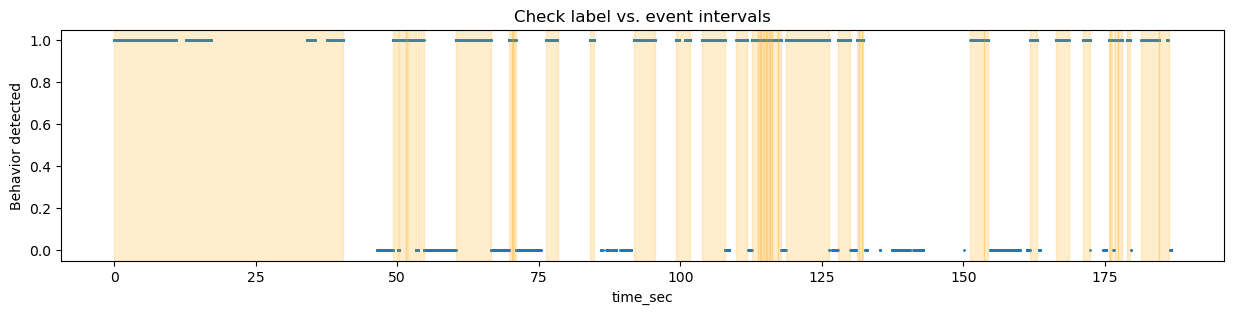

In [34]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()

In [39]:
df_wide[(df_wide['time_sec'] <= 83.983)][['time_sec', 'behavior']]

,time_sec,behavior
0,0.000,other
1,0.017,other
2,0.033,other
3,0.050,other
4,0.067,other
...,...,...
3412,78.250,other
3413,78.267,other
3414,78.283,other
3415,78.300,other


In [44]:
df_wide[(df_wide['time_sec'] <= 161.833)][['time_sec', 'x_0', 'behavior']]

,time_sec,x_0,behavior
0,0.000,0.708243,other
1,0.017,0.704539,other
2,0.033,0.705226,other
3,0.050,0.705681,other
4,0.067,0.705191,other
...,...,...,...
6342,161.483,0.659011,NaN
6343,161.500,0.650474,NaN
6344,161.733,0.553143,NaN
6345,161.767,0.551102,NaN


In [47]:
df_clean = df_wide.dropna(subset=['behavior'])

df_wide = df_clean

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,0,0.000,Left,1,0.708243,0.719291,0.727318,0.724962,0.719267,0.761391,...,0.005726,0.045007,0.038370,0.016824,0.004854,0.056219,0.046449,0.030469,0.021166,other
1,1,0.017,Left,1,0.704539,0.718753,0.726468,0.724693,0.719930,0.758074,...,0.012776,0.050035,0.046846,0.024530,0.010572,0.059823,0.053464,0.037889,0.027743,other
2,2,0.033,Left,1,0.705226,0.717288,0.725942,0.724882,0.716832,0.757138,...,0.018361,0.052838,0.052203,0.031122,0.017393,0.063038,0.058572,0.043977,0.034257,other
3,3,0.050,Left,1,0.705681,0.717237,0.725261,0.723949,0.716978,0.757697,...,0.020988,0.054712,0.054826,0.033886,0.020161,0.065152,0.061163,0.046578,0.036845,other
4,4,0.067,Left,1,0.705191,0.717206,0.725325,0.723914,0.716847,0.757876,...,0.022463,0.056497,0.057239,0.035797,0.021545,0.066991,0.063516,0.048749,0.038730,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7026,11162,186.033,Left,1,0.718923,0.734442,0.744641,0.737008,0.725827,0.716548,...,0.073814,0.059239,0.079612,0.080803,0.079390,0.077209,0.092420,0.097564,0.100938,place
7027,11163,186.050,Left,1,0.721087,0.718295,0.722373,0.717360,0.707138,0.719830,...,0.074102,0.063238,0.083196,0.082396,0.079161,0.082537,0.097840,0.101979,0.103759,place
7028,11164,186.067,Left,1,0.727917,0.702366,0.698836,0.695893,0.689087,0.718508,...,0.076106,0.056464,0.078685,0.081523,0.079859,0.073924,0.091870,0.098662,0.101877,place
7029,11165,186.083,Left,1,0.725409,0.714362,0.713132,0.704889,0.694947,0.718424,...,0.064528,0.052929,0.070086,0.070388,0.068468,0.068776,0.082118,0.086649,0.089392,place


In [50]:
df_wide['dataset_id'] = '09'

cols = df_wide.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide = df_wide[cols]

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_16789/1142807303.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wide['dataset_id'] = '09'


,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,09,0,0.000,Left,1,0.708243,0.719291,0.727318,0.724962,0.719267,...,0.005726,0.045007,0.038370,0.016824,0.004854,0.056219,0.046449,0.030469,0.021166,other
1,09,1,0.017,Left,1,0.704539,0.718753,0.726468,0.724693,0.719930,...,0.012776,0.050035,0.046846,0.024530,0.010572,0.059823,0.053464,0.037889,0.027743,other
2,09,2,0.033,Left,1,0.705226,0.717288,0.725942,0.724882,0.716832,...,0.018361,0.052838,0.052203,0.031122,0.017393,0.063038,0.058572,0.043977,0.034257,other
3,09,3,0.050,Left,1,0.705681,0.717237,0.725261,0.723949,0.716978,...,0.020988,0.054712,0.054826,0.033886,0.020161,0.065152,0.061163,0.046578,0.036845,other
4,09,4,0.067,Left,1,0.705191,0.717206,0.725325,0.723914,0.716847,...,0.022463,0.056497,0.057239,0.035797,0.021545,0.066991,0.063516,0.048749,0.038730,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7026,09,11162,186.033,Left,1,0.718923,0.734442,0.744641,0.737008,0.725827,...,0.073814,0.059239,0.079612,0.080803,0.079390,0.077209,0.092420,0.097564,0.100938,place
7027,09,11163,186.050,Left,1,0.721087,0.718295,0.722373,0.717360,0.707138,...,0.074102,0.063238,0.083196,0.082396,0.079161,0.082537,0.097840,0.101979,0.103759,place
7028,09,11164,186.067,Left,1,0.727917,0.702366,0.698836,0.695893,0.689087,...,0.076106,0.056464,0.078685,0.081523,0.079859,0.073924,0.091870,0.098662,0.101877,place
7029,09,11165,186.083,Left,1,0.725409,0.714362,0.713132,0.704889,0.694947,...,0.064528,0.052929,0.070086,0.070388,0.068468,0.068776,0.082118,0.086649,0.089392,place


In [53]:
df_wide.to_csv("handlandmark_wide_09.csv", index=False)